In [1]:
import os

import contextily as ctx
import dask.dataframe as dd
import geopandas as gpd
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import osmnx
import pandas as pd
from scipy.spatial import ConvexHull

### Compute

In [7]:
# Carrega os dados
enriched_points = dd.read_csv(
    "./anglova_metrics_enriched/points_enriched_metrics.csv",
).compute()
enriched_points['t'] = pd.to_datetime(enriched_points['t'])
enriched_trajectories_df = pd.read_csv(
    "./anglova_metrics_enriched/trajectories_enriched_metrics.csv",
)


In [8]:
osmnx.settings.max_query_area_size = 2500000000 * 6161

In [ ]:
def map_matching(df, network_type="drive"):
    gdf = gpd.GeoDataFrame(
        df, geometry=gpd.points_from_xy(df.x, df.y), crs="EPSG:4326"
    )
    bounds = gdf.total_bounds
    graph = osmnx.graph_from_bbox(
        bounds, network_type=network_type
    )
    nearest_edges = osmnx.nearest_edges(
        graph, gdf.x, gdf.y
    )
    gdf_edges = osmnx.graph_to_gdfs(graph, nodes=False)
    # find the closest point, inside the line, to move the external point
    geometries = gdf['geometry']
    for i in range(len(nearest_edges)):
        e = nearest_edges[i]
        df_edges = gdf_edges[
            (gdf_edges.index.get_level_values("u") == e[0])
            & (gdf_edges.index.get_level_values("v") == e[1])
        ]
        line = df_edges['geometry']
        nearest_point = line.iloc[0].interpolate(line.iloc[0].project(geometries.iloc[i]))
        gdf.loc[i, 'geometry_matched'] = nearest_point
    return gdf

In [28]:
# Resample enriched_points to 1 point per minute, keeping all points
enriched_points_resampled = enriched_points.set_index('t').resample('1T').apply(lambda x: x)
enriched_points_resampled = enriched_points_resampled.reset_index()

C:\Users\edgar\AppData\Local\Temp\ipykernel_7208\2800161337.py:2: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  enriched_points_resampled = enriched_points.set_index('t').resample('1T').apply(lambda x: x)


In [30]:
# Calculate the bounding box of enriched_points
gdf = map_matching(enriched_points_resampled)

In [33]:
gdf.to_csv("./anglova_metrics_enriched/points_matcheds.csv")

### Plot

In [2]:
gdf = gpd.read_file("./anglova_metrics_enriched/points_matcheds.csv")

In [3]:
from shapely.wkt import loads
from shapely.geometry import Point

# Convert 'geometry_matched' column to shapely Point objects if it's in WKT format
gdf["geometry_matched"] = gdf["geometry_matched"].apply(lambda geom: loads(geom) if isinstance(geom, str) else geom)

# Now extract the x and y coordinates
gdf["geometry_matched_x"] = gdf["geometry_matched"].apply(lambda point: point.x if isinstance(point, Point) else None)
gdf["geometry_matched_y"] = gdf["geometry_matched"].apply(lambda point: point.y if isinstance(point, Point) else None)

In [4]:
from moveminer.metrics.distance_calculation import HaversineDistanceCalculation


# Ensure the columns used in the calculation are converted to float
gdf["y"] = gdf["y"].astype(float)
gdf["x"] = gdf["x"].astype(float)
gdf["geometry_matched_y"] = gdf["geometry_matched_y"].astype(float)
gdf["geometry_matched_x"] = gdf["geometry_matched_x"].astype(float)

# Perform the Haversine distance calculation
haversine = HaversineDistanceCalculation()
gdf["match_distance"] = gdf.apply(
    lambda row: haversine.calculate(
        row["y"],
        row["x"],
        row["geometry_matched_y"],
        row["geometry_matched_x"],
    ),
    axis=1,
)

c:\Users\edgar\anaconda3\envs\moveminer\lib\site-packages\pyproj\crs\crs.py:143: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
c:\Users\edgar\anaconda3\envs\moveminer\lib\site-packages\pyproj\crs\crs.py:143: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [5]:
gdf["on_the_road"] = gdf['match_distance'] < 0.01

In [6]:
correlation = gdf['match_distance'].corr(gdf['speed'])
print("Correlation between match_distance and speed:", correlation)

Correlation between match_distance and speed: -0.40448827580476127


In [7]:
def save_plot(filename):
    output_path = "./assets/On The Road"
    if not os.path.exists(output_path):
        os.makedirs(output_path)
    plt.savefig(
        f"{output_path}/{filename}.png",
        bbox_inches="tight",
    )
    plt.savefig(
        f"{output_path}/{filename}.pdf",
        bbox_inches="tight",
    )


C:\Users\edgar\AppData\Local\Temp\ipykernel_21260\2499542742.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  gdf["t"] = pd.to_datetime(gdf["t"])


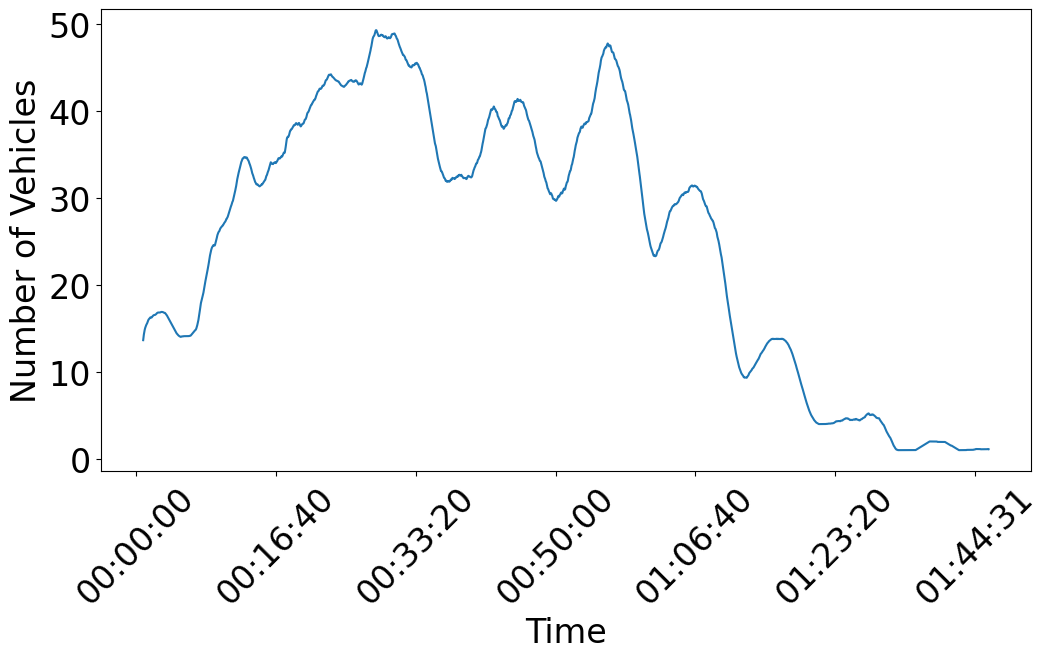

In [11]:
# Convert the 't' column to datetime if not already done
gdf["t"] = pd.to_datetime(gdf["t"])
gdf["t"] = gdf["t"].dt.strftime("%H:%M:%S")
plt.rcParams.update({"font.size": 24})
# Group by time and count the number of vehicles "on_the_road"
on_the_road_over_time = gdf[gdf["on_the_road"]].groupby("t").size()

# Plot the result
on_the_road_over_time.rolling(window=100, center=True).mean().plot(
    figsize=(12, 6), xlabel="Time", ylabel="Number of Vehicles"
)
plt.xticks(rotation=45)
save_plot('Anglova')

for category in [
    "Company",
    "Company Type",
    "Platoon",
    "Platoon Type",
    "Vehicle Function",
    "Vehicle Type",
    "Command",
]:
    # Group by 't' and 'Company', then count the number of vehicles "on_the_road"
    on_the_road_per_company = (
        gdf[gdf["on_the_road"]]
        .groupby(["t", category])
        .size()
        .unstack(fill_value=0)
    )

    # Plot the result for each company
    on_the_road_per_company.rolling(window=100, center=True).mean().plot(
        figsize=(12, 6), xlabel="Time", ylabel="Number of Vehicles"
    )
    plt.xticks(rotation=45)
    save_plot(category)
    plt.close()
